In [1]:
import pandas as pd
import numpy as np
import sqlite3

from plotnine import *
from mizani.formatters import percent_format
from itertools import product
from joblib import Parallel, delayed, cpu_count

In [4]:
tidy_finance = sqlite3.connect(
  database="data/tidy_finance_python.sqlite"
)

crsp_monthly = pd.read_sql_query(
  sql="SELECT * FROM crsp_monthly", 
  con=tidy_finance, 
  parse_dates={"date"}
)

factors_ff3_monthly = pd.read_sql_query(
  sql="SELECT * FROM factors_ff3_monthly", 
  con=tidy_finance, 
  parse_dates={"date"}
)

/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_54283/709974064.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_54283/709974064.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


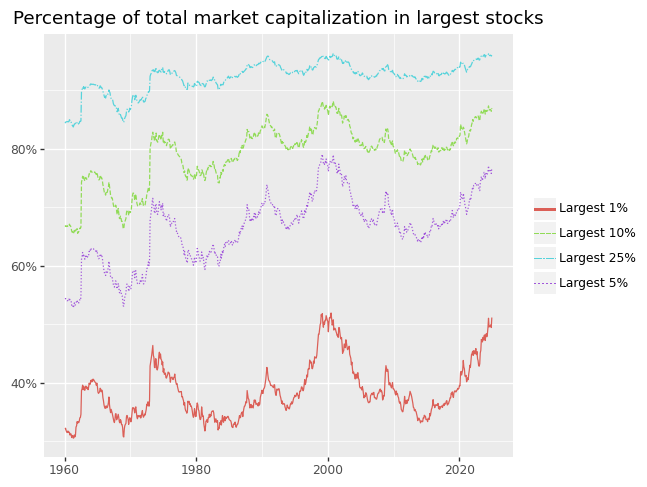

In [5]:
market_cap_concentration = (crsp_monthly
  .groupby("date")
  .apply(lambda x: x.assign(
    top01=(x["mktcap"] >= np.quantile(x["mktcap"], 0.99)),
    top05=(x["mktcap"] >= np.quantile(x["mktcap"], 0.95)),
    top10=(x["mktcap"] >= np.quantile(x["mktcap"], 0.90)),
    top25=(x["mktcap"] >= np.quantile(x["mktcap"], 0.75)))
  )
  .reset_index(drop=True)
  .groupby("date")
  .apply(lambda x: pd.Series({
    "Largest 1%": x["mktcap"][x["top01"]].sum()/x["mktcap"].sum(),
    "Largest 5%": x["mktcap"][x["top05"]].sum()/x["mktcap"].sum(),
    "Largest 10%": x["mktcap"][x["top10"]].sum()/x["mktcap"].sum(),
    "Largest 25%": x["mktcap"][x["top25"]].sum()/x["mktcap"].sum()
    })
  )
  .reset_index()
  .melt(id_vars="date", var_name="name", value_name="value")
)

plot_market_cap_concentration = (
  ggplot(market_cap_concentration, 
         aes(x="date", y="value", 
         color="name", linetype="name")) +
  geom_line() +
  scale_y_continuous(labels=percent_format()) +
  scale_x_date(name="", date_labels="%Y") +
  labs(x="", y="", color="", linetype="", 
       title=("Percentage of total market capitalization in "
              "largest stocks")) +
  theme(legend_title=element_blank())
)
plot_market_cap_concentration.draw()

/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_54283/3883520510.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


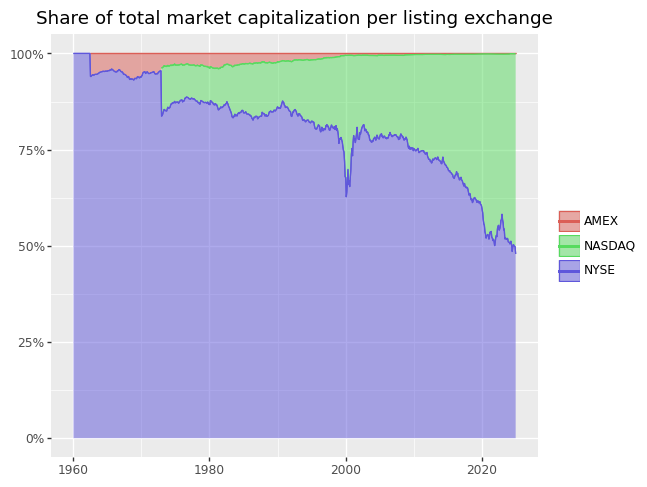

In [6]:
market_cap_share = (crsp_monthly
  .groupby(["date", "exchange"])
  .aggregate({"mktcap": "sum"})
  .reset_index(drop=False)
  .groupby("date")
  .apply(lambda x:
    x.assign(total_market_cap=lambda x: x["mktcap"].sum(),
             share=lambda x: x["mktcap"]/x["total_market_cap"]
             )
    )
  .reset_index(drop=True)
)

plot_market_cap_share = (
  ggplot(market_cap_share, 
         aes(x="date", y="share", 
             fill="exchange", color="exchange")) +
  geom_area(position="stack", stat="identity", alpha=0.5) +
  geom_line(position="stack") +
  scale_y_continuous(labels=percent_format()) +
  scale_x_date(name="", date_labels="%Y") +
  labs(x="", y="", fill="", color="",
       title="Share of total market capitalization per listing exchange") +
  theme(legend_title=element_blank())
)
plot_market_cap_share.draw()

In [7]:
def compute_summary(data, variable, filter_variable, percentiles):
    """Compute summary statistics for a given variable and percentiles."""
    
    summary = (data
      .get([filter_variable, variable])
      .groupby(filter_variable)
      .describe(percentiles=percentiles)
    ) 
    
    summary.columns = summary.columns.droplevel(0)
    
    summary_overall = (data
      .get(variable)
      .describe(percentiles=percentiles)
    )
    
    summary.loc["Overall", :] = summary_overall
    
    return summary.round(0)

compute_summary(
  crsp_monthly[crsp_monthly["date"] == crsp_monthly["date"].max()],
  variable="mktcap",
  filter_variable="exchange",
  percentiles=[0.05, 0.5, 0.95]
)

,count,mean,std,min,5%,50%,95%,max
exchange,,,,,,,,
AMEX,155.0,208.0,537.0,2.0,4.0,47.0,930.0,3921.0
NASDAQ,2382.0,12535.0,141802.0,1.0,5.0,310.0,20238.0,3785304.0
NYSE,1256.0,21862.0,63583.0,15.0,179.0,4048.0,90119.0,732872.0
Overall,3793.0,15120.0,118288.0,1.0,7.0,725.0,47107.0,3785304.0


In [8]:
def assign_portfolio(data, exchanges, sorting_variable, n_portfolios):
    """Assign portfolio for a given sorting variable."""
    
    breakpoints = (data
      .query(f"exchange in {exchanges}")
      .get(sorting_variable)
      .quantile(np.linspace(0, 1, num=n_portfolios+1), 
                interpolation="linear")
      .drop_duplicates()
    )
    breakpoints.iloc[[0, -1]] = [-np.Inf, np.Inf]
    
    assigned_portfolios = pd.cut(
      data[sorting_variable],
      bins=breakpoints,
      labels=range(1, breakpoints.size),
      include_lowest=True,
      right=False
    )
    
    return assigned_portfolios

In [9]:
def calculate_returns(data, value_weighted):
    """Calculate (value-weighted) returns."""
    
    if value_weighted:
      return np.average(data["ret_excess"], weights=data["mktcap_lag"])
    else:
      return data["ret_excess"].mean()
          
def compute_portfolio_returns(n_portfolios=10, 
                              exchanges=["NYSE", "NASDAQ", "AMEX"], 
                              value_weighted=True, 
                              data=crsp_monthly):
    """Compute (value-weighted) portfolio returns."""
    
    returns = (data
      .groupby("date")
      .apply(lambda x: x.assign(
        portfolio=assign_portfolio(x, exchanges, 
                                   "mktcap_lag", n_portfolios))
      )
      .reset_index(drop=True)
      .groupby(["portfolio", "date"])
      .apply(lambda x: x.assign(
        ret=calculate_returns(x, value_weighted))
      )
      .reset_index(drop=True)
      .groupby("date")
      .apply(lambda x: 
        pd.Series({"size_premium": x.loc[x["portfolio"].idxmin(), "ret"]-
          x.loc[x["portfolio"].idxmax(), "ret"]}))
      .reset_index(drop=True)
      .aggregate({"size_premium": "mean"})
    )
    
    return returns

In [10]:
ret_all = compute_portfolio_returns(
  n_portfolios=2,
  exchanges=["NYSE", "NASDAQ", "AMEX"],
  value_weighted=True,
  data=crsp_monthly
)

ret_nyse = compute_portfolio_returns(
  n_portfolios=2,
  exchanges=["NYSE"],
  value_weighted=True,
  data=crsp_monthly
)

data = pd.DataFrame([ret_all*100, ret_nyse*100], 
                    index=["NYSE, NASDAQ & AMEX", "NYSE"])
data.columns = ["Premium"]
data.round(2)

/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_54283/898045519.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_54283/898045519.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_54283/898045519.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded f

,Premium
"NYSE, NASDAQ & AMEX",0.04
NYSE,0.13


In [11]:
n_portfolios = [2, 5, 10]
exchanges = [["NYSE"], ["NYSE", "NASDAQ", "AMEX"]]
value_weighted = [True, False]
data = [
  crsp_monthly,
  crsp_monthly[crsp_monthly["industry"] != "Finance"],
  crsp_monthly[crsp_monthly["date"] < "1990-06-01"],
  crsp_monthly[crsp_monthly["date"] >= "1990-06-01"],
]
p_hacking_setup = list(
  product(n_portfolios, exchanges, value_weighted, data)
)

In [12]:
n_cores = cpu_count()-1
p_hacking_results = pd.concat(
  Parallel(n_jobs=n_cores)
  (delayed(compute_portfolio_returns)(x, y, z, w) 
   for x, y, z, w in p_hacking_setup)
)
p_hacking_results = p_hacking_results.reset_index(name="size_premium")

/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_54283/898045519.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_54283/898045519.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_54283/898045519.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded f

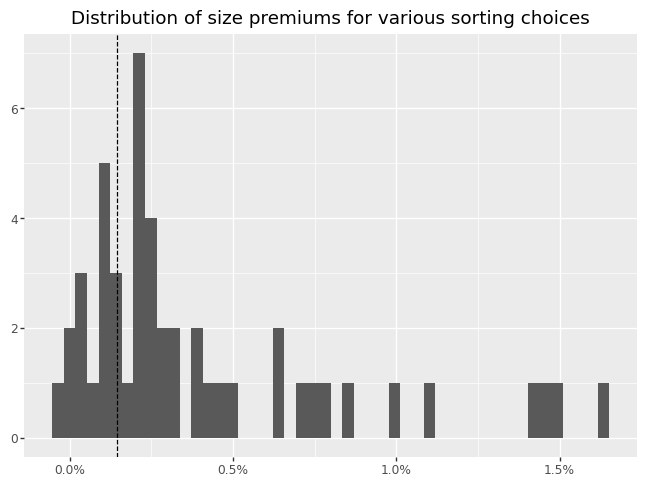

In [13]:
p_hacking_results_figure = (
  ggplot(p_hacking_results, 
         aes(x="size_premium")) +
  geom_histogram(bins=len(p_hacking_results)) +
  scale_x_continuous(labels=percent_format()) +
  labs(x="", y="",
       title="Distribution of size premiums for various sorting choices") +
  geom_vline(aes(xintercept=factors_ff3_monthly["smb"].mean()), 
                 linetype="dashed")
)
p_hacking_results_figure.draw()